In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import sys
from meta_model.utils import ndcg_sim, ndcg, custom_sim
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
sys.path.append("meta_model")
baseline_pairs = {
    "haverage": "manhattan_hamming",
    "fasterpam": "euclidean_hamming",
    "kprototypes": "sqeuclidean_hamming",
}

In [2]:
benchmark_results = {}
benchmark_results_dir = "meta_dataset_creation/data/benchmark_results_prev/"
clustering_algorithms = os.listdir(benchmark_results_dir)
clustering_algorithms

['kprototypes', 'haverage', 'fasterpam']

In [3]:
for algorithm in clustering_algorithms:
    print(algorithm)
    benchmark_results[algorithm] = {}
    for name in os.listdir(os.path.join(benchmark_results_dir, algorithm)):
        print("\t", name)
        benchmark_results[algorithm][name] = {}
        folder_path = os.path.join(benchmark_results_dir, algorithm, name)
        scores_dir = os.path.join(folder_path, "scores/")
        for filename in os.listdir(scores_dir):
            data_id = filename.split('.')[0]
            with open(os.path.join(scores_dir, filename), "rb") as f:
                result = pickle.load(f)
            for sim_pair in result:
                for eval_metric in result[sim_pair]:
                    if eval_metric not in benchmark_results[algorithm][name]:
                        benchmark_results[algorithm][name][eval_metric] = {}
                    if data_id not in benchmark_results[algorithm][name][eval_metric]:
                        benchmark_results[algorithm][name][eval_metric][data_id] = {}
                    benchmark_results[algorithm][name][eval_metric][data_id][sim_pair] = \
                        max([v["score"] for v in result[sim_pair][eval_metric] \
                            if eval_metric != "sil" or 0.05 <= v["params"]["gamma" if algorithm=="kprototypes" else "alpha"] <= (20 if algorithm=="kprototypes" else 0.95)])
                    # if eval_metric == "sil":
                    #     print(sim_pair, sorted(result[sim_pair][eval_metric], reverse=True, key= lambda v: v["score"])[0])
        
        for eval_metric in benchmark_results[algorithm][name]:
            benchmark_results[algorithm][name][eval_metric] = \
                pd.DataFrame.from_dict(benchmark_results[algorithm][name][eval_metric], orient='index')
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].fillna(-1)
            benchmark_results[algorithm][name][eval_metric] = \
                benchmark_results[algorithm][name][eval_metric].replace(-1, -10)
            print(eval_metric, benchmark_results[algorithm][name][eval_metric].shape)
        
        if len(benchmark_results[algorithm][name]) > 0:
            indices = np.random.permutation(benchmark_results[algorithm][name]["acc"].shape[0])
            for eval_metric in benchmark_results[algorithm][name]:
                benchmark_results[algorithm][name][eval_metric] = benchmark_results[algorithm][name][eval_metric].iloc[indices]
            
            max_ = benchmark_results[algorithm][name]["acc"].max(axis=1)
            for eval_metric in ["acc", "ari", "purity"]:
                benchmark_results[algorithm][name][eval_metric] = benchmark_results[algorithm][name][eval_metric][max_ >= 0.7]
                print(eval_metric, benchmark_results[algorithm][name][eval_metric].shape)
            print()

kprototypes
	 from_numeric


acc (228, 120)
ari (228, 120)
purity (228, 120)
sil (228, 120)
acc (78, 120)
ari (78, 120)
purity (78, 120)

	 original
acc (182, 120)
ari (182, 120)
purity (182, 120)
sil (182, 120)
acc (93, 120)
ari (93, 120)
purity (93, 120)

haverage
	 from_numeric
	 original
acc (185, 120)
ari (185, 120)
purity (185, 120)
sil (185, 120)
acc (102, 120)
ari (102, 120)
purity (102, 120)

fasterpam
	 original
acc (186, 120)
ari (186, 120)
purity (186, 120)
sil (186, 120)
acc (86, 120)
ari (86, 120)
purity (86, 120)

	 from_numeric


In [4]:
algorithm = 'kprototypes'
eval_metric = 'acc'
benchmark_results[algorithm]["original"][eval_metric].head()

,euclidean_hamming,euclidean_eskin,euclidean_iof,euclidean_of,euclidean_jaccard,euclidean_dice,euclidean_kulsinski,euclidean_rogerstanimoto,euclidean_russellrao,euclidean_sokalmichener,...,euclidean_co-oc,manhattan_co-oc,chebyshev_co-oc,sqeuclidean_co-oc,canberra_co-oc,mahalanobis_co-oc,cosine_co-oc,pearson_co-oc,lorentzian_co-oc,divergence_co-oc
55,0.761290,0.754839,0.761290,0.761290,0.761290,0.780645,0.754839,0.761290,0.780645,0.761290,...,0.774194,0.812903,0.722581,0.767742,0.793548,0.780645,0.767742,0.787097,0.793548,0.787097
831,0.900510,0.882653,0.900510,0.895408,0.890306,0.890306,0.890306,0.885204,0.890306,0.885204,...,0.895408,0.897959,0.892857,0.892857,0.897959,0.890306,0.890306,0.895408,0.897959,0.897959
43892,0.635493,0.628973,0.635289,0.634067,0.627139,0.626936,0.626936,0.639568,0.627751,0.639568,...,0.613692,0.612062,0.621638,0.612062,0.706398,0.612062,0.621027,0.612062,0.612062,0.612062
1110,0.837000,0.862300,0.862500,0.893300,0.836800,0.812100,0.846800,0.837000,0.837100,0.837000,...,0.863400,0.865800,0.791700,0.863200,0.934000,-10.000000,0.895900,0.899700,0.864200,0.934300
35,0.726257,0.712291,0.759777,0.709497,0.734637,0.734637,0.734637,0.726257,0.709497,0.726257,...,0.815642,0.815642,0.815642,0.810056,0.812849,0.807263,0.706704,-10.000000,0.810056,0.807263


In [5]:
benchmark_results[algorithm]["from_numeric"][eval_metric].head()

,euclidean_hamming,euclidean_eskin,euclidean_iof,euclidean_of,euclidean_co-oc,euclidean_jaccard,euclidean_dice,euclidean_kulsinski,euclidean_rogerstanimoto,euclidean_russellrao,...,divergence_iof,divergence_of,divergence_co-oc,divergence_jaccard,divergence_dice,divergence_kulsinski,divergence_rogerstanimoto,divergence_russellrao,divergence_sokalmichener,divergence_sokalsneath
26_1061,0.859813,0.859813,0.859813,0.859813,0.859813,0.859813,0.859813,0.859813,0.859813,0.859813,...,0.775701,0.785047,0.785047,0.785047,0.785047,0.785047,0.785047,0.775701,0.785047,0.785047
347_1543,0.250000,0.252778,0.250000,0.332407,-10.000000,0.250000,0.250000,0.332407,0.250000,0.332407,...,0.394444,0.401852,-10.000000,0.401852,0.401852,0.401852,0.401852,0.401852,0.401852,0.401852
247_476,0.640000,0.640000,0.640000,0.680000,0.800000,0.640000,0.640000,0.640000,0.640000,0.640000,...,0.620000,0.660000,0.800000,0.620000,0.640000,0.620000,0.620000,0.620000,0.620000,0.620000
170_1464,0.704545,0.589572,0.704545,0.704545,0.704545,0.703209,0.703209,0.704545,0.700535,0.704545,...,0.671123,0.673797,0.704545,0.667112,0.671123,0.671123,0.667112,0.671123,0.667112,0.665775
437_1050,0.584133,0.891875,0.584133,0.765195,0.554702,0.584133,0.584133,0.584133,0.584133,0.777991,...,0.760077,0.760077,0.760077,0.760077,0.760077,0.760077,0.760077,0.760077,0.760077,0.760077


In [6]:
dataset_statistics = ["n_instances", "n_features",
                      "dim", "num_on_cat", "n_num_att", "n_cat_att"]
attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_num_att", "std_num_att",  # "kurtosis_num_att", "skewness_num_att",
        "card_cat_att", "entropy_cat_att",
        "covariance",
    ]
]

isolation_forest = [f"isolation_forest_{i}" for i in range(10)]

proposed_attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        # "kurtosis_squared_num_att", "skewness_squared_num_att",
        "means_squared_num_att", "std_squared_num_att",
        # "kurtosis_internal_product_num_att", "skewness_internal_product_num_att",
        "means_internal_product_num_att", "std_internal_product_num_att",
        "mutual_info_cat_att",
        "std_freq_cat_att"
    ]
]

In [7]:
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.ensemble import IsolationForest
mixed_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/original/meta_features.csv", index_col="id").drop_duplicates()
# mixed_meta_df = mixed_meta_df[(np.abs(stats.zscore(mixed_meta_df)) < 3).all(axis=1)]
indices = IsolationForest(random_state=0).fit_predict(mixed_meta_df.to_numpy())>0
mixed_meta_df = mixed_meta_df.iloc[indices]
mixed_meta_df.index = mixed_meta_df.index.astype(str)
print("Number of meta features:", mixed_meta_df.shape[1])
print("Number of instances:", mixed_meta_df.shape[0])

Number of meta features: 61
Number of instances: 159


In [8]:
numeric_meta_df = pd.read_csv("meta_dataset_creation/data/meta_features/from_numeric/meta_features.csv", index_col="id").drop_duplicates()
numeric_meta_df.index = numeric_meta_df.index.astype(str)
print("Number of meta features:", numeric_meta_df.shape[1])
print("Number of instances:", numeric_meta_df.shape[0])

Number of meta features: 61
Number of instances: 500


In [9]:
from sklearn.metrics import pairwise_distances
index = benchmark_results[algorithm]["original"][eval_metric].index
mixed_Y = benchmark_results[algorithm]["original"][eval_metric][index.isin(mixed_meta_df.index)].to_numpy()
if eval_metric in ["acc", "purity"]:
    mixed_Yn = np.array([y/max(y) for y in mixed_Y])
    mixed_Yn[mixed_Yn > 0] **= 4
    mixed_Yn[mixed_Yn<0] = -1
elif eval_metric == "ari":
    mixed_Yn = np.array([(y+0.5)/max(y+0.5) for y in mixed_Y])
    mixed_Yn[mixed_Yn > 0] **= 4
    mixed_Yn[mixed_Yn<0] = -1
else:
    mixed_Yn = np.array([(y+1)/max(y+1) for y in mixed_Y])
    mixed_Yn[mixed_Yn > 0] **= 4
    mixed_Yn[mixed_Yn<0] = -1

# index = benchmark_results[algorithm]["from_numeric"][eval_metric].index
# numeric_Y = benchmark_results[algorithm]["from_numeric"][eval_metric][index.isin(numeric_meta_df.index)].to_numpy()
# numeric_Yn = np.array([y/max(y) for y in numeric_Y])
# numeric_Yn[numeric_Yn>0] **= 4
# numeric_Yn[numeric_Yn<0] = -1

In [10]:
index = benchmark_results[algorithm]["original"][eval_metric].index
mixed_X = mixed_meta_df.loc[[i for i in index if i in mixed_meta_df.index]].to_numpy()
# landmark = []
# for data_id in [i for i in index if i in mixed_meta_df.index]:
#     filename = os.path.join(benchmark_results_dir, f"{algorithm}/original/scores/{data_id}.pickle")
#     with open(filename, "rb") as f:
#         obj = pickle.load(f)
#         scores = [v["score"] for v in obj[baseline_pairs[algorithm]]['sil']]
#         # print(len(scores))
#         landmark.append(scores)
# landmark = np.array(landmark)
# mixed_X = np.c_[mixed_X, landmark]

# index = benchmark_results[algorithm]["from_numeric"][eval_metric].index
# numeric_X = numeric_meta_df.loc[[i for i in index if i in numeric_meta_df.index]].to_numpy()
sc = StandardScaler().fit(mixed_X) # StandardScaler().fit(np.concatenate((mixed_X, numeric_X))) #
mixed_X = sc.transform(mixed_X) # mixed_X/mixed_X.shape[1] #
# numeric_X = sc.transform(numeric_X) # numeric_X/numeric_X.shape[1] #

mixed_X.shape #, numeric_X.shape

(78, 61)

In [11]:
X = mixed_X # np.concatenate((mixed_X, numeric_X))
# X2 = X[:, [i for i in range(mixed_meta_df.shape[1]) if mixed_meta_df.columns.values[i] in dataset_statistics+attributes_statistics]]
Y = mixed_Y # np.concatenate((mixed_Y, numeric_Y))
Yn = mixed_Yn # np.concatenate((mixed_Yn, numeric_Yn))

In [12]:
import random

import torch
import torch.nn as nn

from tqdm import tqdm

import typing
from typing import List

Parameters = List[torch.nn.parameter.Parameter]

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(f"Pytorch will use device {device}")

# turn off gradients as we will not be needing them
torch.set_grad_enabled(False)

in_dim = X.shape[1]
out_dim = 16

print(in_dim, out_dim)

Pytorch will use device cuda:0
61 16


In [52]:
from sklearn.model_selection import cross_val_score, KFold
from meta_model.ranking import ALL_MODELS
from sklearn.metrics import make_scorer
from meta_model.ranking import scorer
import pygad

# scorer = make_scorer(lambda yt, yp: np.mean([(y[y>0][np.argmax(yp[i][y>0])]/max(y))**1 for i, y in enumerate(yt)]))
# scorer = make_scorer(lambda yt, yp: np.mean(ndcg(yt, yp, p=5)))

metrics = ["euclidean", "manhattan", "cosine"]
weights = ["uniform", "distance"]

def get_params(net: torch.nn.Sequential) -> Parameters:
    '''
    Gets the parameters from a PyTorch model stored as an nn.Sequential
    
    @params
        network (nn.Sequential): A pytorch model
    @returns
        Parameters: the parameters of the model
    '''
    params = []
    for layer in net:
        if hasattr(layer, 'weight') and layer.weight != None:
            params.append(layer.weight)
        if hasattr(layer, 'bias') and layer.bias != None:
            params.append(layer.bias)
    return params

def set_params(net: torch.nn.Sequential, params: Parameters) -> torch.nn.Sequential:
    '''
    Sets the parameters for an nn.Sequential
    
    @params
        network (torch.nn.Sequential): A network to change the parameters of 
        params (Parameters): Parameters to place into the model
    @returns
        torch.nn.Sequential: A model the the provided parameters
    '''
    i = 0
    for layerid, layer in enumerate(net):
        if hasattr(layer, 'weight') and layer.weight != None:
            net[layerid].weight = params[i]
            i += 1
        if hasattr(layer, 'bias') and layer.bias != None:
            net[layerid].bias = params[i]
            i += 1
    return net

def fitness(solution: Parameters, net: torch.nn.Sequential, X, Y) -> float:
    '''
    Evaluate a solution, a set of weights and biases for the network
    
    @params
        solution (Parameters): parameters to test the fitness of
        net (torch.nn.Sequential): A network for testing the parameters with
        render (bool): whether or not to draw the agent interacting with the environment as it trains
    @returns
        float: The fitness of the solution
    '''
    # net = set_params(net, solution)

    # Xe = net(torch.tensor(X, device=device).float()).cpu().detach().numpy()
    # n_neighbors = 5
    # metric = "euclidean"
    # w = "distance"
    # knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
    # fitness = np.mean(cross_val_score(knn, Xe, Y, cv=10, scoring=scorer))
    # return fitness
    yp = net(torch.tensor(X, device=device).float()).cpu().detach().numpy()
    return np.mean([(y[y>-1][np.argmax(yp[i][y>0])]/max(y))**1 for i, y in enumerate(Y)])


def select(pop: List[Parameters], fitnesses: np.ndarray) -> List[Parameters]:
    '''
    Select a new population
    
    @params
        pop (List[Parameters]): The entire population of parameters
        fitnesses (np.ndarray): the fitnesses for each entity in the population
    @returns
        List[Parameters]: A new population made of fitter individuals
    '''
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True, p=fitnesses/fitnesses.sum())
    return [pop[i] for i in idx]

def crossover(parent1: Parameters, pop: List[Parameters]) -> Parameters:
    '''
    Crossover two individuals and produce a child.
    
    This is done by randomly splitting the weights and biases at each layer for the parents and then
    combining them to produce a child
    
    @params
        parent1 (Parameters): A parent that may potentially be crossed over
        pop (List[Parameters]): The population of solutions
    @returns
        Parameters: A child with attributes of both parents or the original parent1
    '''
    if np.random.rand() < CROSS_RATE:
        i = np.random.randint(0, POP_SIZE, size=1)[0]
        parent2 = pop[i]
        child = []
        split = np.random.rand()
        
        for p1l, p2l in zip(parent1, parent2):
            splitpoint = int(len(p1l)*split)
            new_param = nn.parameter.Parameter(torch.cat([p1l[:splitpoint], p2l[splitpoint:]]))
            child.append(new_param)

        return child
    else:
        return parent1


def gen_mutate(shape: torch.Size) -> torch.tensor:
    '''
    Generate a tensor to use for random mutation of a parameter
    
    @params
        shape (torch.Size): The shape of the tensor to be created
    @returns
        torch.tensor: a random tensor
    '''
    return torch.randn(shape).to(device)*MUTATION_FACTOR
    
def mutate(child: Parameters) -> Parameters:
    '''
    Mutate a child
    
    @params
        child (Parameters): The original parameters
    @returns
        Parameters: The mutated child
    '''
    for i in range(len(child)):
        for j in range(len(child[i])):
            if np.random.rand() < MUTATION_RATE:
                child[i][j] += gen_mutate(child[i][j].shape)
    return child

In [ ]:
%%time

# hyperparameters for genetic algorithm
POP_SIZE = 16
CROSS_RATE = 0.8
MUTATION_RATE = 0.2
MUTATION_FACTOR = 0.001
N_GENERATIONS = 200
FITNESS_EARLY_STOP_THRESH = 0.999

# the pytorch neural network to train
net = nn.Sequential(
    nn.Linear(in_dim, 64),
    # nn.ReLU(),
    # nn.Linear(32, out_dim),
    nn.ReLU(),
    nn.Linear(64, 256),
    nn.ReLU(),
    nn.Linear(256, Y.shape[1]),
    nn.Softmax(dim=1),
).to(device)

# get the required parameter shapes
base = get_params(net)
shapes = [param.shape for param in base]

# build a population
pop = []
for i in range(POP_SIZE):
    entity = []
    for shape in shapes:
        # if fan in and fan out can be calculated (tensor is 2d) then using kaiming uniform initialisation
        # as per nn.Linear
        # otherwise use uniform initialisation between -0.5 and 0.5
        try:
            rand_tensor = nn.init.kaiming_uniform_(torch.empty(shape)).to(device)
        except ValueError:
            rand_tensor = nn.init.uniform_(torch.empty(shape), -0.2, 0.2).to(device)
        entity.append((torch.nn.parameter.Parameter(rand_tensor)))
    pop.append(entity)

# train
for i in range(N_GENERATIONS):
    # get fitnesses
    fitnesses = np.array([fitness(entity, net, X[selected_datasets], Y[selected_datasets]) for entity in pop])
    # fitnesses = np.array(Parallel(n_jobs=-1, verbose=0)(delayed(fitness)(entity, net, X[selected_datasets], Y[selected_datasets]) for entity in pop))
    # calculate average fitness of population
    avg_fitness = fitnesses.sum()/len(fitnesses)
    
    # print info of generation
    print(f"Generation {i}: Average Fitness is {avg_fitness} | Max Fitness is {fitnesses.max()}")
    
    if avg_fitness > FITNESS_EARLY_STOP_THRESH:
        break
    # select a new population
    
    fittest = list(pop[fitnesses.argmax()])
    pop = select(pop, fitnesses)
    random.shuffle(pop)
    pop = pop[:-1]
    pop.append(fittest)
    pop2 = list(pop)
    # go through the population and crossover and mutate
    for i in range(len(pop)-1):
        child = crossover(pop[i], pop2)
        child = mutate(child)
        pop[i] = child

In [241]:
import torch
from pygad import torchga
import pygad
from sklearn.model_selection import KFold
def fitness_func(ga_instance, solution, sol_idx):
    global train, torch_ga, model
    yp = pygad.torchga.predict(
        model=model,
        solution=solution,
        data=torch.tensor(X[train], device=device).float()
    ).cpu().detach().numpy()
    l = [(y[y>-1][np.argmax(yp[i][y>0])]/max(y))**1 for i, y in enumerate(Y[train])]
    # l = ndcg(Yn[train], yp, p=10)
    return np.mean(l) #- 1e-5*(solution**2).sum()**0.5 # - np.std(l)

def on_generation(ga_instance):
    if ga_instance.generations_completed % 50 == 0:
        print(f"Generation = {ga_instance.generations_completed}", end=", ")
        print(f"Fitness    = {ga_instance.best_solution()[1]}")

yp = np.zeros(Y.shape)
cv = KFold(n_splits=5, shuffle=True)
for train, test in cv.split(X):
    print()
    print("Training...")
    model = nn.Sequential(
        nn.Linear(in_dim, Y.shape[1]),
        nn.Softmax(dim=1),
    ).to(device)
    # print(model)

    # Create an instance of the pygad.torchga.TorchGA class to build the initial population.
    torch_ga = torchga.TorchGA(model=model,
                            num_solutions=10)

    # Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/pygad.html#pygad-ga-class
    num_generations = 500 # Number of generations.
    num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.
    initial_population = torch_ga.population_weights # Initial population of network weights

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        initial_population=initial_population,
                        fitness_func=fitness_func,
                        on_generation=on_generation)

    ga_instance.run()

    # After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
    # ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

    # Returning the details of the best solution.
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print(f"Fitness value of the best solution = {solution_fitness}")
    print(f"Index of the best solution : {solution_idx}")

    print("Testing...")
    # Make predictions based on the best solution.
    yp[test] = pygad.torchga.predict(
        model=model,
        solution=solution,
        data=torch.tensor(X[test], device=device).float()
    ).cpu().detach().numpy()
    print(np.mean([(y[y>-1][np.argmax(yp[i][y>0])]/max(y))**1 for i, y in enumerate(Y[test])]))
print("Predictions : \n", yp)


Training...
Generation = 50, Fitness    = 0.7979716410480424
Generation = 100, Fitness    = 0.82663343932238
Generation = 150, Fitness    = 0.8365709179672547
Generation = 200, Fitness    = 0.8429456682347559
Generation = 250, Fitness    = 0.8468243765909534
Generation = 300, Fitness    = 0.8483708550225687
Generation = 350, Fitness    = 0.8563278913284372
Generation = 400, Fitness    = 0.8569193245089275
Generation = 450, Fitness    = 0.8569193245089275
Generation = 500, Fitness    = 0.8569193245089275
Fitness value of the best solution = 0.8569193245089275
Index of the best solution : 0
Testing...
0.6023484430028629

Training...
Generation = 50, Fitness    = 0.8119936906105328
Generation = 100, Fitness    = 0.8561789400682948
Generation = 150, Fitness    = 0.8562231390358302
Generation = 200, Fitness    = 0.870424243017564
Generation = 250, Fitness    = 0.880409856413222
Generation = 300, Fitness    = 0.8885797310375678
Generation = 350, Fitness    = 0.8887468892763406
Generation = 

In [242]:
(solution**2).sum()**0.5

180.92893676407616

In [243]:
from meta_model.utils import ndcg
from meta_model.ranking import ALL_MODELS
from meta_model.ranking_tree import RankingTree
from sklearn.model_selection import KFold, cross_val_predict

cv = KFold(n_splits=5)
predictions = {}
predictions["AR"] = np.zeros(Y.shape)
i = 0

# models["KNN"] = models["KNN"].cross_val_fit(X2[selected_datasets], Y[selected_datasets], n_splits=5) #
# predictions["KNN"] = cross_val_predict(models["KNN"], X2[selected_datasets], Y[selected_datasets], cv=cv)

# n_neighbors = solution2[X2.shape[1]]
# metric = metrics[solution2[X2.shape[1]+1]]
# w = weights[solution2[X2.shape[1]+2]]
# knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
# predictions["KNN-FS"] = cross_val_predict(knn, X2[selected_datasets][:, selected_features2], Y[selected_datasets], cv=cv)

model = ALL_MODELS["KNN"]().cross_val_fit(X, Y, n_splits=5) #
predictions["AMF-KNN"] = cross_val_predict(model, X, Y, cv=5)

model = ALL_MODELS["RF"]().cross_val_fit(X, Y, n_splits=5) #
predictions["AMF-RF"] = cross_val_predict(model, X, Y, cv=5)

# fittest = pop[fitnesses.argmax()]
# net = set_params(net, fittest)
# Xe = net(torch.tensor(X[selected_datasets], device=device).float()).cpu().detach().numpy()
# models["KNN-AMF-FS"], cv_scores = models["KNN-AMF-FS"].cross_val_fit(Xe, Y[selected_datasets], n_splits=5, return_cv_scores=True) #
# predictions["KNN-AMF-FS"] = cross_val_predict(models["KNN-AMF-FS"], Xe, Y[selected_datasets], cv=5)

# fittest = pop[fitnesses.argmax()]
# net = set_params(net, fittest)
# Xe = net(torch.tensor(X[selected_datasets], device=device).float()).cpu().detach().numpy()
# n_neighbors = 5
# metric = "euclidean"
# w = "distance"
# knn = ALL_MODELS["KNN"](n_neighbors=n_neighbors, metric=metric, weights=w)
predictions["AMF-ML-KNN"] = yp

for train, test in cv.split(X):
    predictions["AR"][test] = np.array([
        [np.mean([v for v in Y[train, j]]) for j in range(Y.shape[1])]
        for _ in test
    ])
# predictions["AR"][selected_datasets[test]] = np.array([
#     [np.mean([v for v in Y[selected_datasets[train], j] if v > 0]) for j in range(Y.shape[1])]
#     for _ in test
# ])

In [244]:
similarity_pairs = benchmark_results[algorithm]["original"][eval_metric].columns
sim_pairs_index = dict(zip(similarity_pairs, range(len(similarity_pairs))))

ndcg_ranks = [1, 3, 5, 10, 15, 20]
n_bests = [1, 3, 5, 10]
ndcg_scores = {
    model_name: {p: np.zeros(len(X)) for p in ndcg_ranks}
    for model_name in predictions
} #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}

lb_scores = np.zeros(len(X))
rb_scores = {k: np.zeros(len(X)) for k in n_bests}
mb_scores = np.zeros(len(X))
model_scores = {
    model_name: {k: np.zeros(len(X)) for k in n_bests}
    for model_name in predictions
} #| {'ensemble': {k: np.zeros(len(test_index)) for k in n_bests}}

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for p in ndcg_ranks:
        ndcg_scores[name][p] = ndcg(Yn, Y_pred, p=p)

for name, Y_pred in predictions.items():
    Y_pred = np.array(Y_pred)
    for k in n_bests:
        model_scores[name][k] = np.array(
            [max(y[y > -1][np.argsort(-Y_pred[i][y > -1])[:k]]) for i, y in enumerate(Y)])

for k in n_bests:
    rb_scores[k] = np.array(
        [max(np.random.choice(y[y > -1], k)) for y in Y])

lb_scores = Y[:, sim_pairs_index[baseline_pairs[algorithm]]]
mb_scores = np.array([max(y) for y in Y])

/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homedir/adiop/workspace/simrec-for-mdc/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


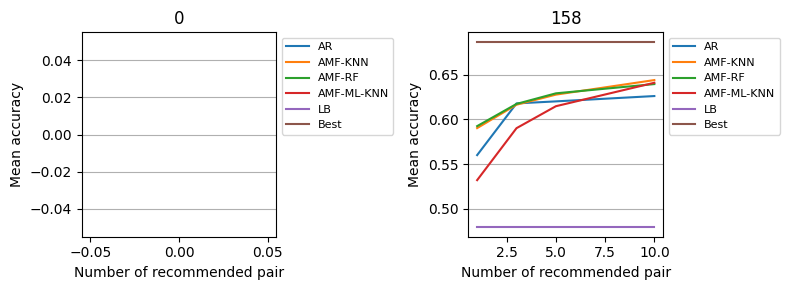

In [245]:
import matplotlib.pyplot as plt

list_indices = [
    [i for i, y in enumerate(Y) if np.mean(1 - y[y>-1]/max(y[y>-1])) < 0.0], #test_index[i] in base_datasets and # i in test and
    [i for i, y in enumerate(Y) if np.mean(1 - y[y>-1]/max(y[y>-1])) >= 0.]
]
rows, cols = 1, len(list_indices)
plt.figure(figsize=(cols*4, rows*3))
subplot_num = 1
exclude = [] #"KNN with aug.", "RF with aug." - "KNN", "RF", "AE+KNN", "AE+RF"
for indices in list_indices:
    scores = {k:v for k, v in model_scores.items() if k not in exclude} 
    # scores["RB"] = rb_scores
    scores["LB"] = lb_scores
    scores["Best"] = mb_scores

    y = {key: [] for key in scores}

    for name, score in scores.items():
        for k in n_bests:
            u = score[indices] if name in ["LB", "Best"] else score[k][indices]
            y[name].append(np.mean(u))

    plt.subplot(rows, cols, subplot_num)
    for name, values in y.items():
        plt.plot(n_bests, values, label=name)
    plt.ylabel("Mean accuracy")
    plt.xlabel("Number of recommended pair")
    # plt.ylim((0.67, 0.9))
    plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
    plt.grid(axis="y")
    plt.title(len(indices))
    subplot_num += 1
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

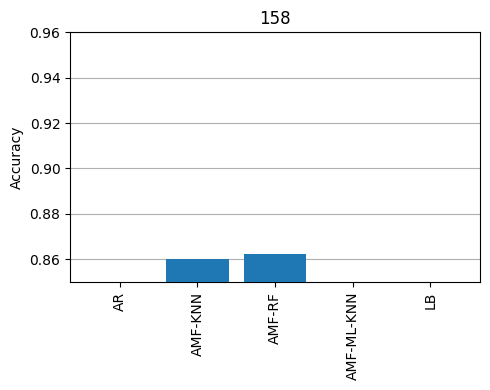

In [246]:
import matplotlib.pyplot as plt

indices = [i for i, y in enumerate(Y) if np.mean(1 - y[y>-1]/max(y[y>-1])) >= 0]

exclude = []
scores = {k:v for k, v in model_scores.items() if k not in exclude} 
# scores["RB"] = rb_scores
scores["LB"] = lb_scores

y = {key: [] for key in scores}
k = 1
best_scores = mb_scores[indices]
for name, score in scores.items():
    u = score[indices] if name in ["LB", "Best"] else score[k][indices]
    y[name] = np.mean(u/best_scores)

plt.figure(figsize=(5, 4))
plt.bar(y.keys(), y.values(), zorder=5)
plt.ylabel("Accuracy")
plt.ylim((0.85, 0.96))
plt.xticks(rotation="vertical")
# plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
plt.grid(axis="y")
plt.title(len(indices))
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

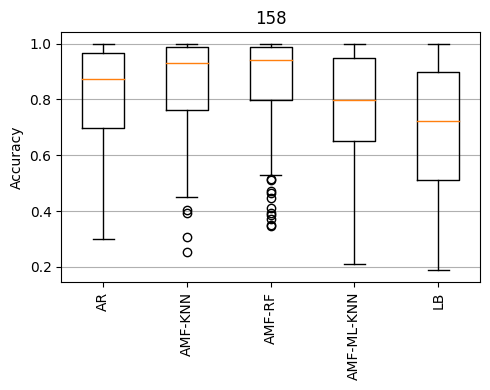

In [247]:
import matplotlib.pyplot as plt

indices = [i for i, y in enumerate(Y) if np.mean(1 - y[y>-1]/max(y[y>-1])) >= 0.]

exclude = []
scores = {k:v for k, v in model_scores.items() if k not in exclude} 
# scores["RB"] = rb_scores
scores["LB"] = lb_scores

y = {key: [] for key in scores}
k = 1
best_scores = mb_scores[indices]
for name, score in scores.items():
    u = score[indices] if name in ["LB", "Best"] else score[k][indices]
    y[name] = u/best_scores

plt.figure(figsize=(5, 4))
plt.boxplot(y.values(), labels=y.keys())
plt.ylabel("Accuracy")
# plt.ylim((0.67, 0.9))
plt.xticks(rotation="vertical")
# plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1))
plt.grid(axis="y")
plt.title(len(indices))
plt.tight_layout()
# plt.savefig("output/mean_acc2.svg")
plt.show()

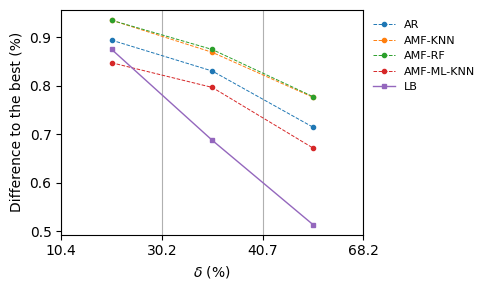

In [248]:
baselines = ["LB"]
k = 1
plt.figure(figsize=(5, 3))
# if j == 0:
#     ax = plt.subplot(2, 1, 1)
# else:
#     ax = plt.subplot(2, 1, 2)
# res = results[algo]

best_scores = mb_scores
y = {}
l = [np.mean(1 - y[y>-1]/max(y[y>-1])) for i, y in enumerate(Y)]
x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])

x[0] -= 1e-4
diff = 0.025
list_indices = [
    [xr < np.mean(1 - y[y>-1]/max(y[y>-1])) <= x[r+1] for i, y in enumerate(Y)]
    for r, xr in enumerate(x[:-1])
] #

for model_name, scores in model_scores.items():
    y[model_name] = []
    for i, indices in enumerate(list_indices):
        # new_ind = [val and lb_scores[j] >, 0, for j, val in enumerate(indices)]
        v = np.mean(((scores[k])/best_scores)[indices])
        y[model_name].append(v)

y["LB"] = []
for i, indices in enumerate(list_indices):
    v = np.mean(((lb_scores)/best_scores)[indices])
    y["LB"].append(v)

n_bar = len(y)
w = 0.8/n_bar
z = np.arange(len(x))
i = 0
max_ = np.zeros(len(list_indices))
min_ = np.ones(len(list_indices))*100
for model_name, values in y.items():
    max_ = np.maximum(max_, values)
    min_ = np.minimum(min_, values)
    # plt.plot(z[:-1]+0.5, values, "--", linewidth=0.7, label=None, alpha=1 if i<6 else 0.7, zorder=10)
    # plt.scatter(z[:-1]+0.5, values, label=model_name, s=[10*np.log(sum(val)) for val in list_indices], alpha=1 if i<6 else 0.7, zorder=10)
    plt.plot(z[:-1]+0.5, values, "--o" if model_name not in baselines else "-s", linewidth=0.7 if model_name not in baselines else 1, label=model_name, markersize=3, zorder=10)
    i += 1

for ind, val in enumerate(list_indices):
    if ind >= 1:
        plt.annotate(f"{max_[ind]:.2g}%", (z[ind]+0.5, max_[ind]+1), fontsize=8, ha="center", va="top")

# plt.bar(x[1:]-diff/2, [50 for _ in diff], width=diff[0], zorder=0, label=None, color="None", edgecolor="gray")

plt.xlim((z[0], z[-1]))
plt.ylabel("Difference to the best (%)")
plt.xticks(z, [f"{max(0, val*100):.1f}" for val in x])
# plt.ylim((min(min_)-1, max(max_)+1))
plt.grid(axis="x")
plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
plt.xlabel("$\delta$ (%)")

# if j == 0:
#     plt.legend(fontsize=8, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
# if j == 1: 
#     plt.xlabel("$\delta$ (%)")
# j += 1
# plt.title(names[algo], y=0.83)

plt.tight_layout()
# if savedir is not None:
#     plt.savefig(os.path.join(savedir, f"diff_best_delta_{algo}_{k}.pdf"))
plt.show()

In [249]:
from scipy.stats import wilcoxon

model_names = ["AMF-KNN", "AMF-ML-KNN"]
baselines = ["LB", "RB", "ARB"]
y = {k:{} for k in model_names}
y_ndcg = {k:{} for k in model_names}

for model_name in model_names:
    scores = model_scores[model_name][1]
    baseline_scores = model_scores["AR"][1]
    s, p = wilcoxon(scores, baseline_scores, alternative="greater")
    y[model_name]["(top-1) ARB"] = f"{p:.3f}"

    baseline_scores = ndcg_scores["AR"][10]
    scores = ndcg_scores[model_name][10]
    s, p = wilcoxon(scores, baseline_scores, alternative="greater")
    y[model_name]["(NDCG) ARB"] = f"{p:.3f}"

print(pd.DataFrame.from_dict(y, orient='index'))

           (top-1) ARB (NDCG) ARB
AMF-KNN          0.000      0.000
AMF-ML-KNN       0.955      1.000
